In [41]:
import pandas as pd

df = pd.read_csv("../csv/split_data.csv")
df = df[df["split"] == "training"]
df["breast_birads"].value_counts()

breast_birads
BI-RADS 1    8609
BI-RADS 2    2956
BI-RADS 3     594
BI-RADS 4     493
BI-RADS 5     148
Name: count, dtype: int64

In [42]:
sampled_df = df.groupby('breast_birads', group_keys=False).apply(lambda x: x.sample(min(len(x), 200))).reset_index(drop=True)
print(sampled_df["breast_birads"].value_counts())

breast_birads
BI-RADS 1    200
BI-RADS 2    200
BI-RADS 3    200
BI-RADS 4    200
BI-RADS 5    148
Name: count, dtype: int64


In [43]:
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
import os
import torch

mean = [0.2652, 0.2652, 0.2652]
std = [0.1994, 0.1994, 0.1994]

class Mydataset(Dataset):
    def __init__(self, df, root):
        super(Mydataset, self).__init__()
        self.root = root
        image_paths_df = df["study_id"] + "/" + df["image_id"] +".png"
        self.image_paths = image_paths_df.tolist()
        label_df = df["breast_birads"]
        self.labels = label_df.tolist()
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.image_paths[idx])
        img = self._read_image(img_path, (224,224))
        label = int(self.labels[idx][-1])
        return img, torch.tensor(label).to(torch.long)
    
    def _read_image(self, filepath, new_size):
        image_pil = Image.open(filepath)
        
        # Kiểm tra chế độ của ảnh
        if image_pil.mode != 'L':
            image_pil = image_pil.convert('L')  # Chuyển đổi sang chế độ 'L' (grayscale) nếu cần thiết
        
        # Tạo ảnh RGB từ ảnh đơn kênh bằng cách sao chép giá trị của kênh đó vào cả ba kênh
        image_pil = Image.merge('RGB', (image_pil, image_pil, image_pil))
        
        # Resize ảnh
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        resized_image = transform(image_pil)
        resized_image = resized_image.to(torch.float)
        
        return resized_image
        

In [44]:
from torch import nn
import torch
import torchvision.models as models
import timm

class FeatureExtractModel(nn.Module):
    def __init__(self, model_name: str, embed_dim: int):
        """
        A custom model for Setting 3, which uses different pre-trained models
        based on the specified `model_name`.

        Args:
        - model_name: Name of the pre-trained model to be used
        - embed_dim: Dimension of the output embeddings
        """
        super(FeatureExtractModel, self).__init__()
        self.model_name = model_name
        # Load the specified pre-trained model
        if model_name.startswith('resnet'):
            if model_name == 'resnet50':
                self.model = models.resnet50()
            elif model_name == 'resnet101':
                self.model = models.resnet101()
            elif model_name == 'resnet152':
                self.model = models.resnet152()
            else:
                raise ValueError(f"Unsupported ResNet model: {model_name}")
                
            num_features = self.model.fc.in_features
            self.model.fc = nn.Linear(num_features, embed_dim)
        
        elif model_name.startswith('densenet'):
            if model_name == 'densenet121':
                self.model = models.densenet121()
            else:
                raise ValueError(f"Unsupported DenseNet model: {model_name}")
                
            num_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(num_features, embed_dim)
        
        elif model_name.startswith('vit'):
            self.model = timm.create_model(model_name)

            num_features = self.model.head.in_features
            self.model.head = nn.Linear(num_features, embed_dim)
        
        else:
            raise ValueError(f"Unsupported model: {model_name}")
    
    def forward(self, image):
        return self.model(image)

In [45]:
from torch.utils.data import DataLoader
import os

dataset = Mydataset(sampled_df, "/media/jackson/Data/archive/Processed_Images")
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=os.cpu_count())

model = FeatureExtractModel("resnet50", 512)
check_point = torch.load("../best_new_balance.pt", map_location = torch.device("cpu"))
model.load_state_dict(check_point["model_state_dict"])

<All keys matched successfully>

In [46]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# Lấy embeddings từ mô hình
test_targets = []
test_embeddings = torch.zeros((0, 512))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.eval()
model = model.to(device)
with torch.no_grad():
    for data in tqdm(dataloader):
        inputs, labels = data
        inputs = inputs.to(device)
        output = model(inputs)
        test_targets.append(labels)
        test_embeddings = torch.cat((test_embeddings, output.detach().cpu().flatten().unsqueeze(0)), axis=0)
# Chuyển đổi danh sách thành tensor
test_embeddings = np.array(test_embeddings)
test_targets = np.array(torch.stack(test_targets).flatten())


cuda


100%|██████████| 948/948 [00:33<00:00, 28.45it/s]


/tmp/ipykernel_7342/4162399277.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')


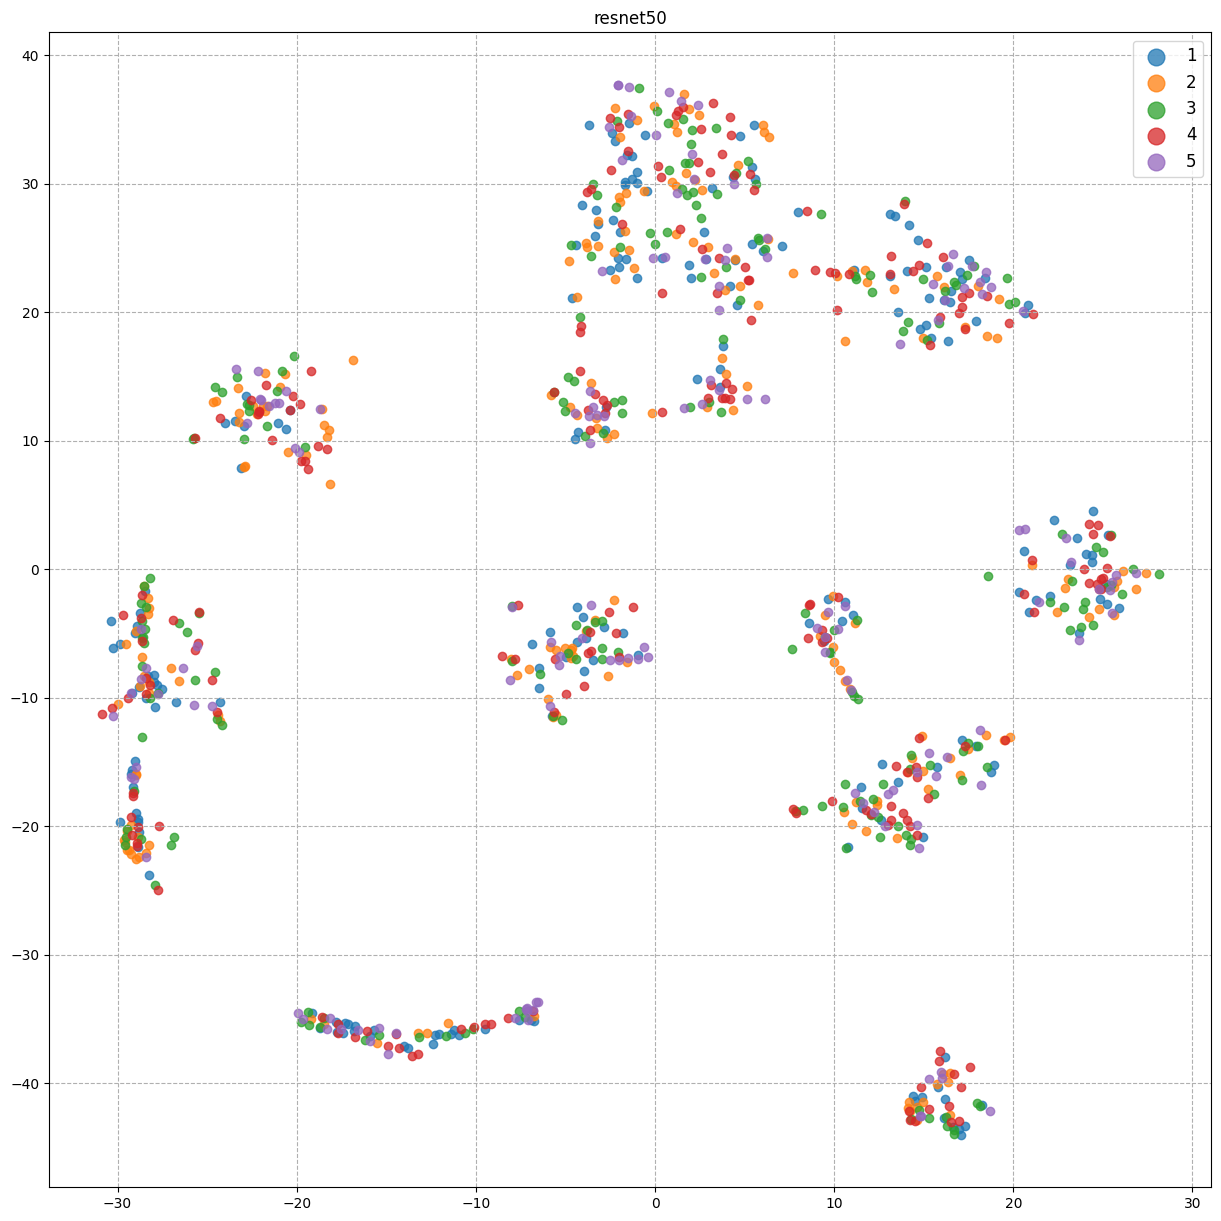

In [49]:
from matplotlib import cm
from sklearn.manifold import TSNE
import numpy as np

embeddings = test_embeddings[~np.isnan(test_targets)]
targets = test_targets[~np.isnan(test_targets)]


tsne = TSNE(n_components=2, init='random', perplexity=26, metric="cosine", early_exaggeration=12, n_iter=1000)
tsne_proj = tsne.fit_transform(embeddings)
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(15,15))
num_categories = 5
for lab in range(1, num_categories+1):
    indices = targets==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], label = lab ,alpha=0.75)
ax.legend(fontsize='large', markerscale=2)
plt.grid(linestyle='--')
plt.title(f"{model.model_name}")
plt.show()

/tmp/ipykernel_7342/1925794884.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')
/tmp/ipykernel_7342/1925794884.py:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(tsne_proj[indices, 0], tsne_proj[indices, 1], label=f'Class {lab}', alpha=0.75, cmap=cmap)
/tmp/ipykernel_7342/1925794884.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')
/tmp/ipykernel_7342/1925794884.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(tsne_proj[indices, 0], tsne_proj[indices, 1], alpha=0.75,

KeyboardInterrupt: 

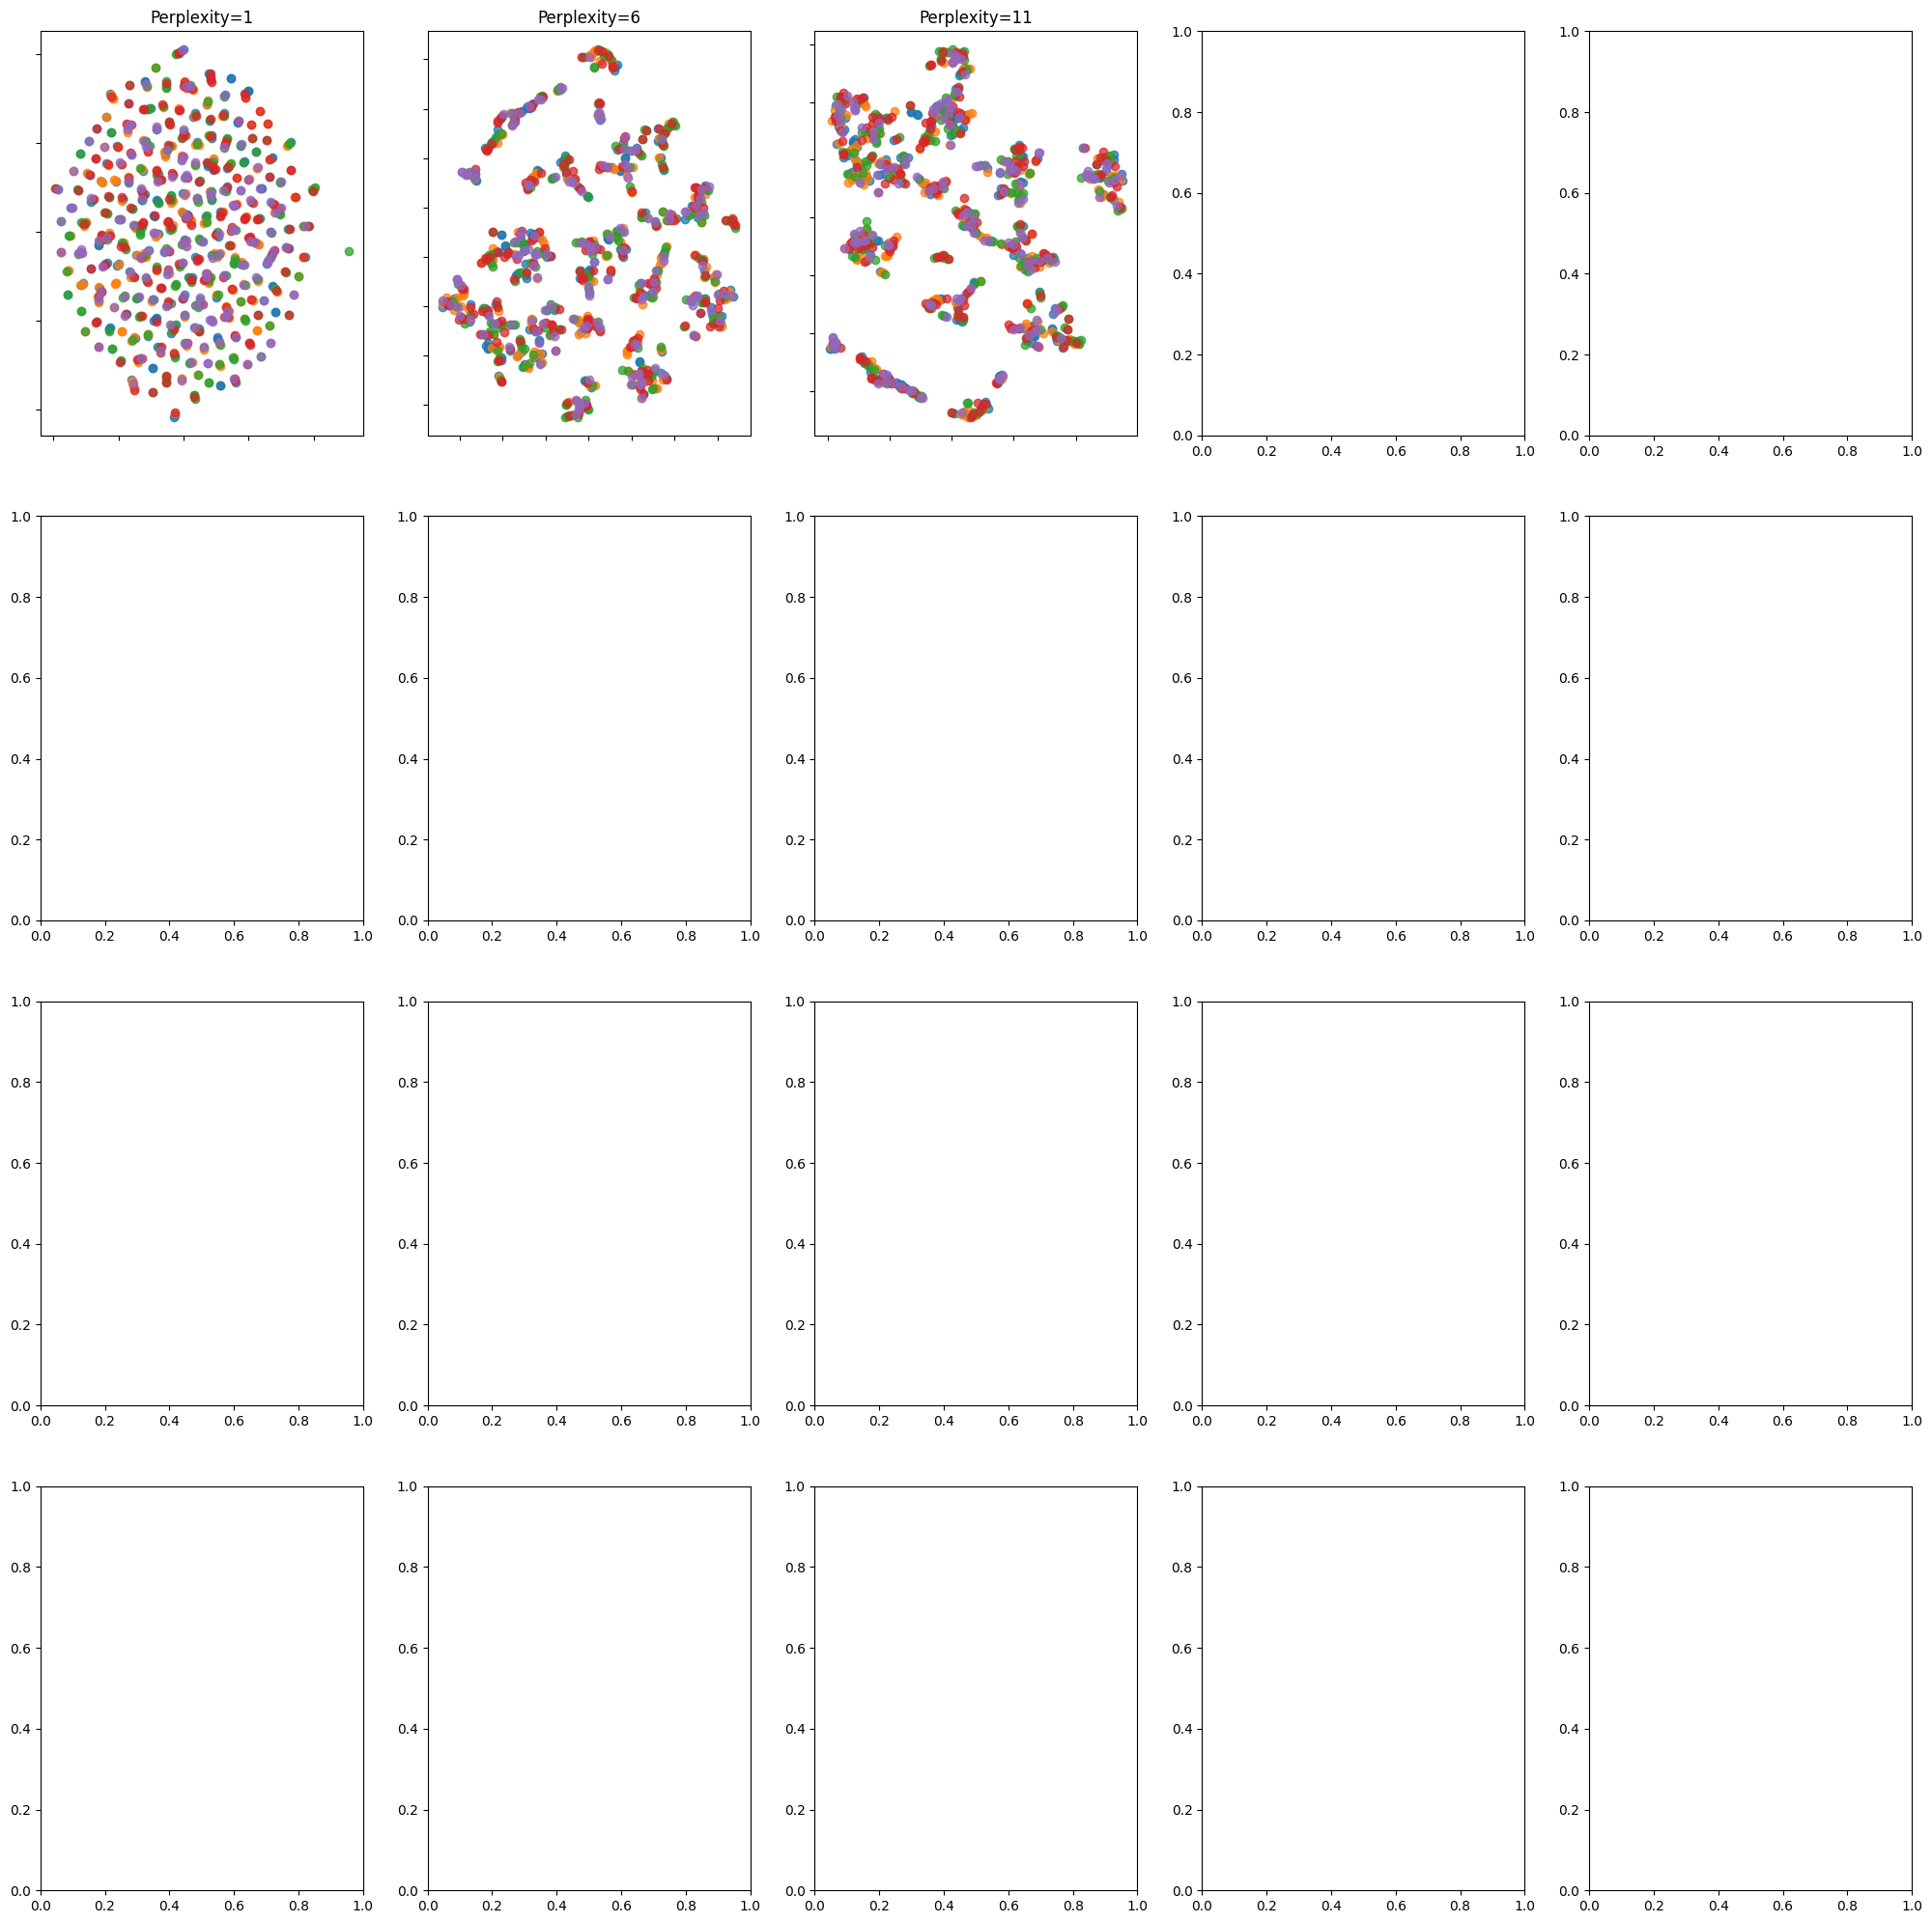

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import NullFormatter
from sklearn.manifold import TSNE

# Assuming `test_embeddings` and `test_targets` are defined somewhere in your code
# Here is a mock definition for illustration:
# test_embeddings = np.random.rand(150, 50)
# test_targets = np.random.randint(1, 6, 150)

embeddings = test_embeddings[~np.isnan(test_targets)]
targets = test_targets[~np.isnan(test_targets)]

# Configuration
n_components = 2
perplexities = list(range(1, 101, 5))  # Perplexities from 1 to 100 with a step of 10
num_categories = 5  # Assuming your targets range from 1 to 5
(fig, subplots) = plt.subplots(4, 5, figsize=(25, 25))  # 2 rows, 5 columns of subplots

# Flatten subplots array for easier iteration
subplots = subplots.flatten()

# Create TSNE projections with different perplexities
for i, perplexity in enumerate(perplexities):
    ax = subplots[i]
    
    tsne = TSNE(n_components=n_components, learning_rate='auto', init='random', perplexity=perplexity, metric="cosine", early_exaggeration=12, n_iter=1000)
    tsne_proj = tsne.fit_transform(embeddings)
    
    cmap = cm.get_cmap('tab20')
    for lab in range(1, num_categories + 1):
        indices = targets == lab
        if i == 0:
            ax.scatter(tsne_proj[indices, 0], tsne_proj[indices, 1], label=f'Class {lab}', alpha=0.75, cmap=cmap)
        else:
            ax.scatter(tsne_proj[indices, 0], tsne_proj[indices, 1], alpha=0.75, cmap=cmap)    
    ax.set_title(f"Perplexity={perplexity}")
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis("tight")
    
fig.legend(fontsize='large', markerscale=2)
plt.suptitle(f"{model.model_name} TSNE with Different Perplexities")
plt.show()
